**To do:**
- Expand dataset
- |-> Train/Val or Train/Val/Test
- ~~Expand to multilabel prediction~~
- Round outputs to nearest decimal -> check performance

## Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
from matplotlib import pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)

In [5]:
names1 = {
    "Q1.1": "aff_tar", "Q1.2": "cog_tar", "Q1.3": "int_tar", "Q1.5": "aff_oth",
     "Q1.6": "cog_oth", "Q1.7": "int_oth"
}

df1 = pd.read_excel("DATA/WMC_DATA_MSA_DF.xlsx")
len1 = len(df1)
df1.drop(columns = ["Q2", "Q1.4", "Q1.8", "Q2.4", "Q2.1",
                    "Q2.2", "Q2.3", "Q2.4", "Q2.5", "Q2.6",
                    "Q2.7", "Q2.8", "V1", 
                    "Q1_letter_count", "Q2_letter_count", 
                    "Q1_word_count", "Q2_word_count", "DataSet "], inplace = True)
df1.drop([0], inplace = True)
df1.rename(columns = names1, inplace = True)
df1.dropna(inplace = True)

df2_temp = pd.read_excel("DATA/5 VEC Data MSA.xlsx")
len2 = len(df2_temp)
df2_temp = df2_temp.dropna()
df2 = pd.DataFrame()
df2["Q1"] = df2_temp["CJ_tend"]
df2["aff_tar"] = df2_temp["CJ_tend_aff_target"]
df2["cog_tar"] = df2_temp["CJ_tend_cog_target"]
df2["int_tar"] = df2_temp["CJ_tend_int_target"]
df2["aff_oth"] = df2_temp["CJ_tend_aff_self"]
df2["cog_oth"] = df2_temp["CJ_tend_cog_self"]
df2["int_oth"] = df2_temp["CJ_tend_cog_self"]
df2.dropna(inplace = True)

# Filter out negative values
df1["total"] = df1["aff_tar"] + df1["cog_tar"] + df1["int_tar"] + df1["aff_oth"] + df1["cog_oth"] + df1["int_oth"]
df2["total"] = df2["aff_tar"] + df2["cog_tar"] + df2["int_tar"] + df2["aff_oth"] + df2["cog_oth"] + df2["int_oth"]
df1 = df1[df1.total > -1]
df2 = df2[df2.total >-1]
df1.drop(columns = ["total"], inplace = True)
df2.drop(columns = ["total"], inplace = True)

print("Dataset 1:", len(df1), "rows")
print("Removed", len1 - len(df1), "rows\n")
print("Dataset 2:", len(df2), "rows")
print("Removed", len2 - len(df2), "rows")

Dataset 1: 128 rows
Removed 43 rows

Dataset 2: 63 rows
Removed 0 rows


In [6]:
df1.head()

,Q1,aff_tar,cog_tar,int_tar,aff_oth,cog_oth,int_oth
1,"A child and a man, presumably the father, are ...",1,0,0,0,0,0
2,Scene opens with a father and daughter riding ...,1,1,0,0,0,0
3,A father and daughter rode their bikes along a...,0,0,0,0,0,0
5,The clip commences with a cross view of the gi...,0,3,1,1,0,0
6,A girl cycles with her father to see him off a...,0,1,1,0,0,0


In [7]:
df2.head()

,Q1,aff_tar,cog_tar,int_tar,aff_oth,cog_oth,int_oth
0,two children are stealing cookies from the jar...,0,0,1,0,0,0
1,This house seems chaotic. The boy is on a stoo...,0,1,0,0,0,0
2,"(Presumably)Mother daydreaming, distracted by ...",0,2,0,0,0,0
3,a woman is washing the dishes\nwater is spilli...,0,0,0,0,0,0
4,"A woman is washing the plates.However, the wat...",0,1,0,0,0,0


In [8]:
def plotHist(df, name):
    fig, axs = plt.subplots(1,6)
    fig.suptitle("Movie: " + name)
    fig.tight_layout()
    cols = [df.columns][0]
    for i in range(6):
        axs[i].hist(df[cols[i+1]])
        axs[i].set_title(cols[i+1])


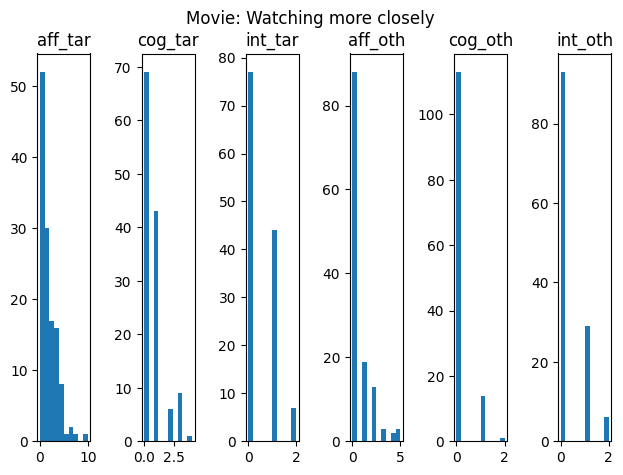

In [9]:
plotHist(df1, "Watching more closely")

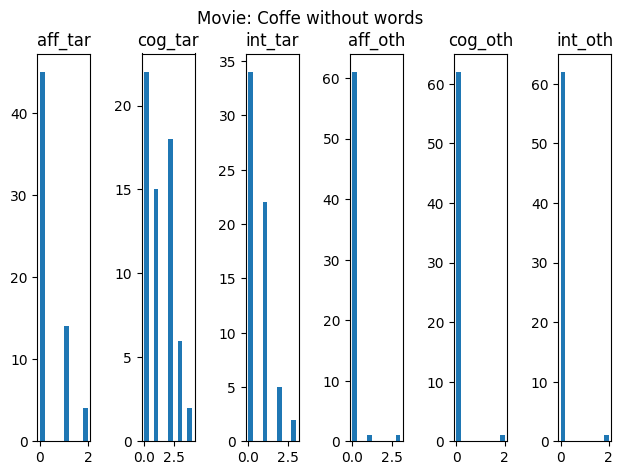

In [10]:
plotHist(df2, "Coffe without words")

In [32]:
# Combine dataframes
trainData = pd.concat([df1, df2])
trainData.reset_index(drop = True, inplace = True)

# Single Attribute Prediction
trainDataSingle = pd.DataFrame()
trainDataSingle["text"] = trainData["Q1"]
trainDataSingle["labels"] = trainData["aff_tar"]

# Multiple Attribute Prediction
trainDataMulti = pd.DataFrame()
trainDataMulti["text"] = trainData["Q1"]
trainDataMulti["labels"] = trainData.iloc[:,1:8].values.tolist()

In [33]:
trainDataMulti.head()

,text,labels
0,"A child and a man, presumably the father, are ...","[1, 0, 0, 0, 0, 0]"
1,Scene opens with a father and daughter riding ...,"[1, 1, 0, 0, 0, 0]"
2,A father and daughter rode their bikes along a...,"[0, 0, 0, 0, 0, 0]"
3,The clip commences with a cross view of the gi...,"[0, 3, 1, 1, 0, 0]"
4,A girl cycles with her father to see him off a...,"[0, 1, 1, 0, 0, 0]"


## TrainingLoader Setup

In [36]:
# Params
# To do: Look into tokenizer params
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [37]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

## Single Attribute Prediction

In [38]:
# Create dataset
trainSingle = MultiLabelDataset(trainDataSingle, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader_single = DataLoader(trainSingle, **train_params)

In [39]:
class nn_single(torch.nn.Module):
    def __init__(self):
        super(nn_single, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.scoreOut = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.scoreOut(pooler)
        return output

model_single = nn_single()

In [42]:
model_single

nn_single(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [57]:
# Training loop
# To do: send tensors to device
EPOCHS = 1
lossVals = []
roundVals = True

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params = model_single.parameters(), lr=1e-4)

model_single.train()
pass # somehow block cant rerun without this
for i in range(EPOCHS):
    for idx, data in enumerate(training_loader_single, 0):
        #print(data)
        ids = data['ids']
        mask = data['mask']
        token_type_ids = data['token_type_ids']
        targets = data['targets']
        targets = targets.reshape(-1,1) # Put in same shape as output

        outputs = model_single(ids, mask, token_type_ids)
        if roundVals == True: outputs = outputs.round()
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        lossVals.append(loss.item())

    print("Epoch", i, ":\tLoss:", loss.item())


Epoch 0 :	Loss: 1.0


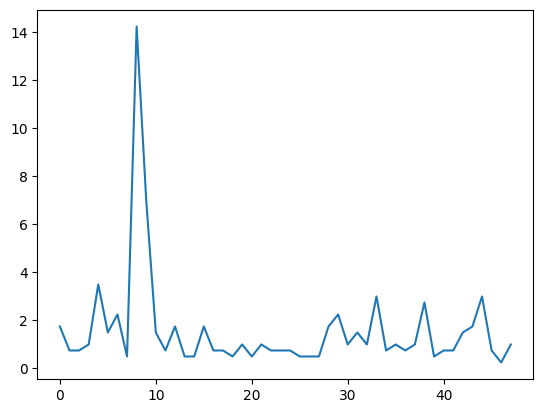

In [58]:
plt.plot(lossVals)

## Multiple Attribute Prediction

In [48]:
# Dataset for Q1
trainDataMulti = pd.DataFrame()
trainDataMulti["text"] = trainData["Q1"]
trainDataMulti["labels"] = trainData.iloc[:,1:8].values.tolist()
trainDataMulti = trainDataMulti.reset_index(drop = True)

trainDataMulti.head()

,text,labels
0,"A child and a man, presumably the father, are ...","[1, 0, 0, 0, 0, 0]"
1,Scene opens with a father and daughter riding ...,"[1, 1, 0, 0, 0, 0]"
2,A father and daughter rode their bikes along a...,"[0, 0, 0, 0, 0, 0]"
3,The clip commences with a cross view of the gi...,"[0, 3, 1, 1, 0, 0]"
4,A girl cycles with her father to see him off a...,"[0, 1, 1, 0, 0, 0]"


In [49]:
# Create dataset
train_multi = MultiLabelDataset(trainDataMulti, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader_multi = DataLoader(train_multi, **train_params)

In [50]:
class nn_multi(torch.nn.Module):
    def __init__(self):
        super(nn_multi, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.scoreOut = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.scoreOut(pooler)
        return output

model_multi = nn_multi()

In [51]:
model_multi

nn_multi(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featur

In [64]:
# Training loop
# To do: send tensors to device
EPOCHS = 1
lossVals = []
roundVals = True

loss_fn = torch.nn.MSELoss() # Use MSE since we're doing regression
optimizer = torch.optim.Adam(params = model_multi.parameters(), lr=1e-4)

model_multi.train()
pass # somehow block cant rerun without this
for i in range(EPOCHS):
    for idx, data in enumerate(training_loader_multi, 0):
        #print(data)
        ids = data['ids']
        mask = data['mask']
        token_type_ids = data['token_type_ids']
        targets = data['targets']

        outputs = model_multi(ids, mask, token_type_ids)
        if roundVals == True: outputs = outputs.round()
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        lossVals.append(loss.item())
        
    print("Epoch", i, ":\tLoss:", loss.item())


Epoch 0 :	Loss: 1.1111111640930176


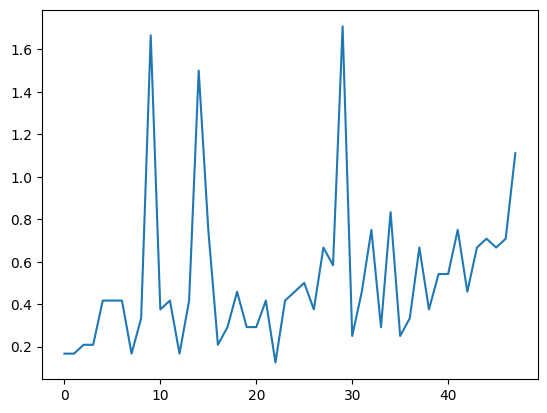

In [65]:
plt.plot(lossVals)